In [92]:
import os
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression 

In [108]:
def load_dataset(path):
    return pd.read_csv(path, header=0)

def correlation(dataset):
    fig = plt.figure(figsize=(8, 5))
    corr = dataset.corr()

    ax = fig.add_subplot(111)
    cax = ax.matshow(corr, cmap="RdBu_r", vmin=-1, vmax=1)
    fig.colorbar(cax)
    plt.xticks(range(len(corr.columns)), corr.columns, fontsize=10, rotation=45, ha='left')
    plt.yticks(range(len(corr.columns)), corr.columns, fontsize=10)
    plt.title('Correlation Matrix', fontsize=15)
    plt.show()

    
def split_dataset(dataset, labels_colname, test_size=0.25):
    global seed
    # Create features and labels 
    features = dataset.drop([labels_colname], axis=1)
    labels = dataset[labels_colname]
    
    # Create training and test set 
    from sklearn.model_selection import train_test_split
    features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=test_size, random_state=seed)
    
    return features_train, features_test, labels_train, labels_test


def scaling(features_train, features_test, scaler="s"):
    # Minmax Normalisation
    if scaler == "m":
        from sklearn.preprocessing import MinMaxScaler 
        minMaxScaler = MinMaxScaler()
        features_train_scaled = minMaxScaler.fit_transform(features_train) 
        features_test_scaled = minMaxScaler.transform(features_test)
    
    # Standardisation
    elif scaler == "s":
        from sklearn.preprocessing import StandardScaler
        standardScaler = StandardScaler()
        features_train_scaled = standardScaler.fit_transform(features_train) 
        features_test_scaled = standardScaler.transform(features_test)
   
    return features_train_scaled, features_test_scaled
    
def imputation(dataset, columns, miss_value, imputer="median"):
    from sklearn.impute import SimpleImputer
    
    # imputation with median strategy
    if imputer == "median":
        im = SimpleImputer(missing_values = miss_value, strategy = 'median')
        dataset_imputed = im.fit_transform(dataset[columns]) # ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
        dataset[columns] = dataset_imputed
    
    # imputation with mean strategy
    elif imputer == "mean":
        im = SimpleImputer(missing_values = miss_value, strategy = 'mean')
        dataset_imputed = im.fit_transform(dataset[columns])
        dataset[columns] = dataset_imputed
    
    return dataset

def rebalance(features_train,labels_train, labels_colname, resampling="up"):
    global seed
    df = pd.concat([features_train,labels_train],axis=1)
    # Separate majority and minority classes
    df_majority = df[df[labels_colname]==0] 
    df_minority = df[df[labels_colname]==1]
    major_samples = len(df_majority)
    minor_samples = len(df_minority)
    from sklearn.utils import resample
    
    if resampling == "up":
        # Upsample samples with replacement for minority class
        df_minority_upsampled = resample(df_minority,
                                         replace=True, # sample with replacement
                                         n_samples=major_samples, # to match majority class
                                         random_state=seed) # reproducible results
        df_upsampled = pd.concat([df_majority, df_minority_upsampled])
        # re-preparing the training sets
        features_train = df_upsampled.drop([labels_colname], axis=1)
        labels_train = df_upsampled[[labels_colname]]
    
    elif resampling == "down":
        # Upsample samples without replacement for minority class
        df_majority_downsampled = resample(df_majority,
                                           replace=False, # sample without replacement
                                           n_samples=minor_samples, # to match minority class
                                           random_state=seed) # reproducible results
        df_downsampled = pd.concat([df_majority_downsampled, df_minority])
        # re-preparing the training sets
        features_train = df_downsampled.drop([labels_colname], axis=1)
        labels_train = df_downsampled[[labels_colname]]
    
    return features_train,labels_train


def display_metrics(labels_test, pred):
    #Check accuracy
    from sklearn.metrics import accuracy_score
    accuracy = accuracy_score(labels_test, pred)
    print('Accuracy: {:.2f}'.format(accuracy))
    
    #Check precision
    from sklearn.metrics import precision_score
    precision = precision_score(labels_test, pred)
    print ('Precision: {:.2f}'.format(precision))

    # Check recall
    from sklearn.metrics import recall_score
    recall = recall_score(labels_test, pred)
    print ('Recall: {:.2f}'.format(recall))

    # Check F1 score
    from sklearn.metrics import f1_score
    f1 = f1_score(labels_test, pred)
    print ('F1 score: {:.2f}'.format(f1))

    # Check with AUROC
    from sklearn.metrics import roc_auc_score
    auroc = roc_auc_score(labels_test, pred)
    print ('AUROC score: {:.2f}'.format(auroc))
    return accuracy, precision, recall, f1, auroc


def plot_roc_curve(labels_test, pred):
    from sklearn.metrics import roc_curve
    fpr, tpr, thresholds = roc_curve(labels_test, pred)
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

def models_boxplot(features_train, labels_train, models, scoring):
    results = []
    names = []
    
    from sklearn import model_selection
    for name, model in models:
        kfold = model_selection.KFold(n_splits=10)
        cv_results = model_selection.cross_val_score(model, features_train,labels_train, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
    # boxplot algorithm comparison
    fig = plt.figure()
    fig.suptitle(f'Algorithm Comparison\n(score={scoring})')
    ax = fig.add_subplot(111)
    plt.boxplot(results)
    ax.set_xticklabels(names)
    plt.show()

In [109]:
seed = 50
data = pd.read_csv("diabetes.csv", header=0)
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [110]:
X = data.drop(['Outcome'], axis=1)
y = data['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = seed, test_size=0.25)

In [111]:
X_train_scaled, X_test_scaled = scaling(X_train, X_test, scaler="s")

KNN: 0.734422 (0.061526)
SVM: 0.772535 (0.058746)
LR: 0.784664 (0.045991)
DT: 0.720296 (0.050101)


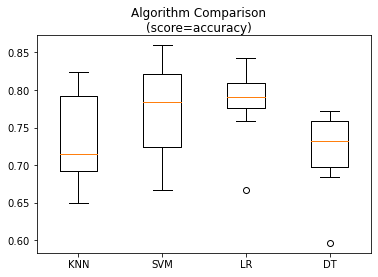

In [112]:
models_boxplot(X_train_scaled,y_train, 
               models=[('KNN', KNeighborsClassifier()),
                       ('SVM', SVC()),
                       ('LR', LogisticRegression()),
                       ('DT', DecisionTreeClassifier())], 
               scoring='accuracy')

In [113]:
columns = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
dataset = imputation(data, columns, 0, imputer="median")
features_train, features_test, labels_train, labels_test = split_dataset(dataset, 'Outcome', test_size=0.25)
features_train,labels_train = rebalance(features_train ,labels_train, 'Outcome', resampling="up")
features_train_scaled, features_test_scaled = scaling(features_train, features_test, scaler="s")

KNN: 0.757018 (0.075018)
SVM: 0.746140 (0.027221)
LR: 0.719509 (0.045313)
DT: 0.868123 (0.066252)


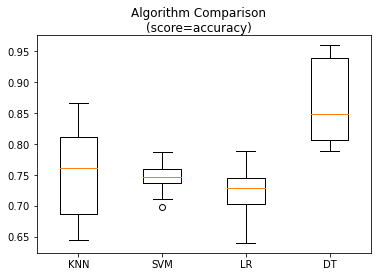

In [114]:
models_boxplot(features_train_scaled,labels_train, 
               models=[('KNN', KNeighborsClassifier()),
                       ('SVM', SVC()),
                       ('LR', LogisticRegression()),
                       ('DT', DecisionTreeClassifier())], 
               scoring='accuracy')

### Gini impurity

In [115]:
clf = DecisionTreeClassifier(criterion='gini')
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

In [116]:
print('Accuracy score on train data:', accuracy_score(y_true=y_train, y_pred=clf.predict(X_train)))
print('Accuracy score on test data:', accuracy_score(y_true=y_test, y_pred=pred))

Accuracy score on train data: 1.0
Accuracy score on test data: 0.7135416666666666


### Enrtopy

In [117]:
clf = DecisionTreeClassifier(criterion='entropy')
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

In [118]:
print('Accuracy score on train data:', accuracy_score(y_true=y_train, y_pred=clf.predict(X_train)))
print('Accuracy score on test data:', accuracy_score(y_true=y_test, y_pred=pred))

Accuracy score on train data: 1.0
Accuracy score on test data: 0.71875


### Tune parameter

In [119]:
clf = DecisionTreeClassifier(criterion='entropy', min_samples_split=50)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

In [120]:
print('Accuracy score on train data:', accuracy_score(y_true=y_train, y_pred=clf.predict(X_train)))
print('Accuracy score on test data:', accuracy_score(y_true=y_test, y_pred=pred))

Accuracy score on train data: 0.8420138888888888
Accuracy score on test data: 0.734375


Accuracy: 0.73
Precision: 0.65
Recall: 0.59
F1 score: 0.62
AUROC score: 0.70


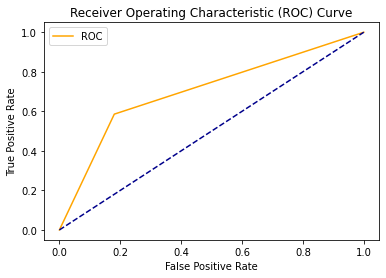

In [121]:
display_metrics(y_test, pred)
plot_roc_curve(y_test, pred)

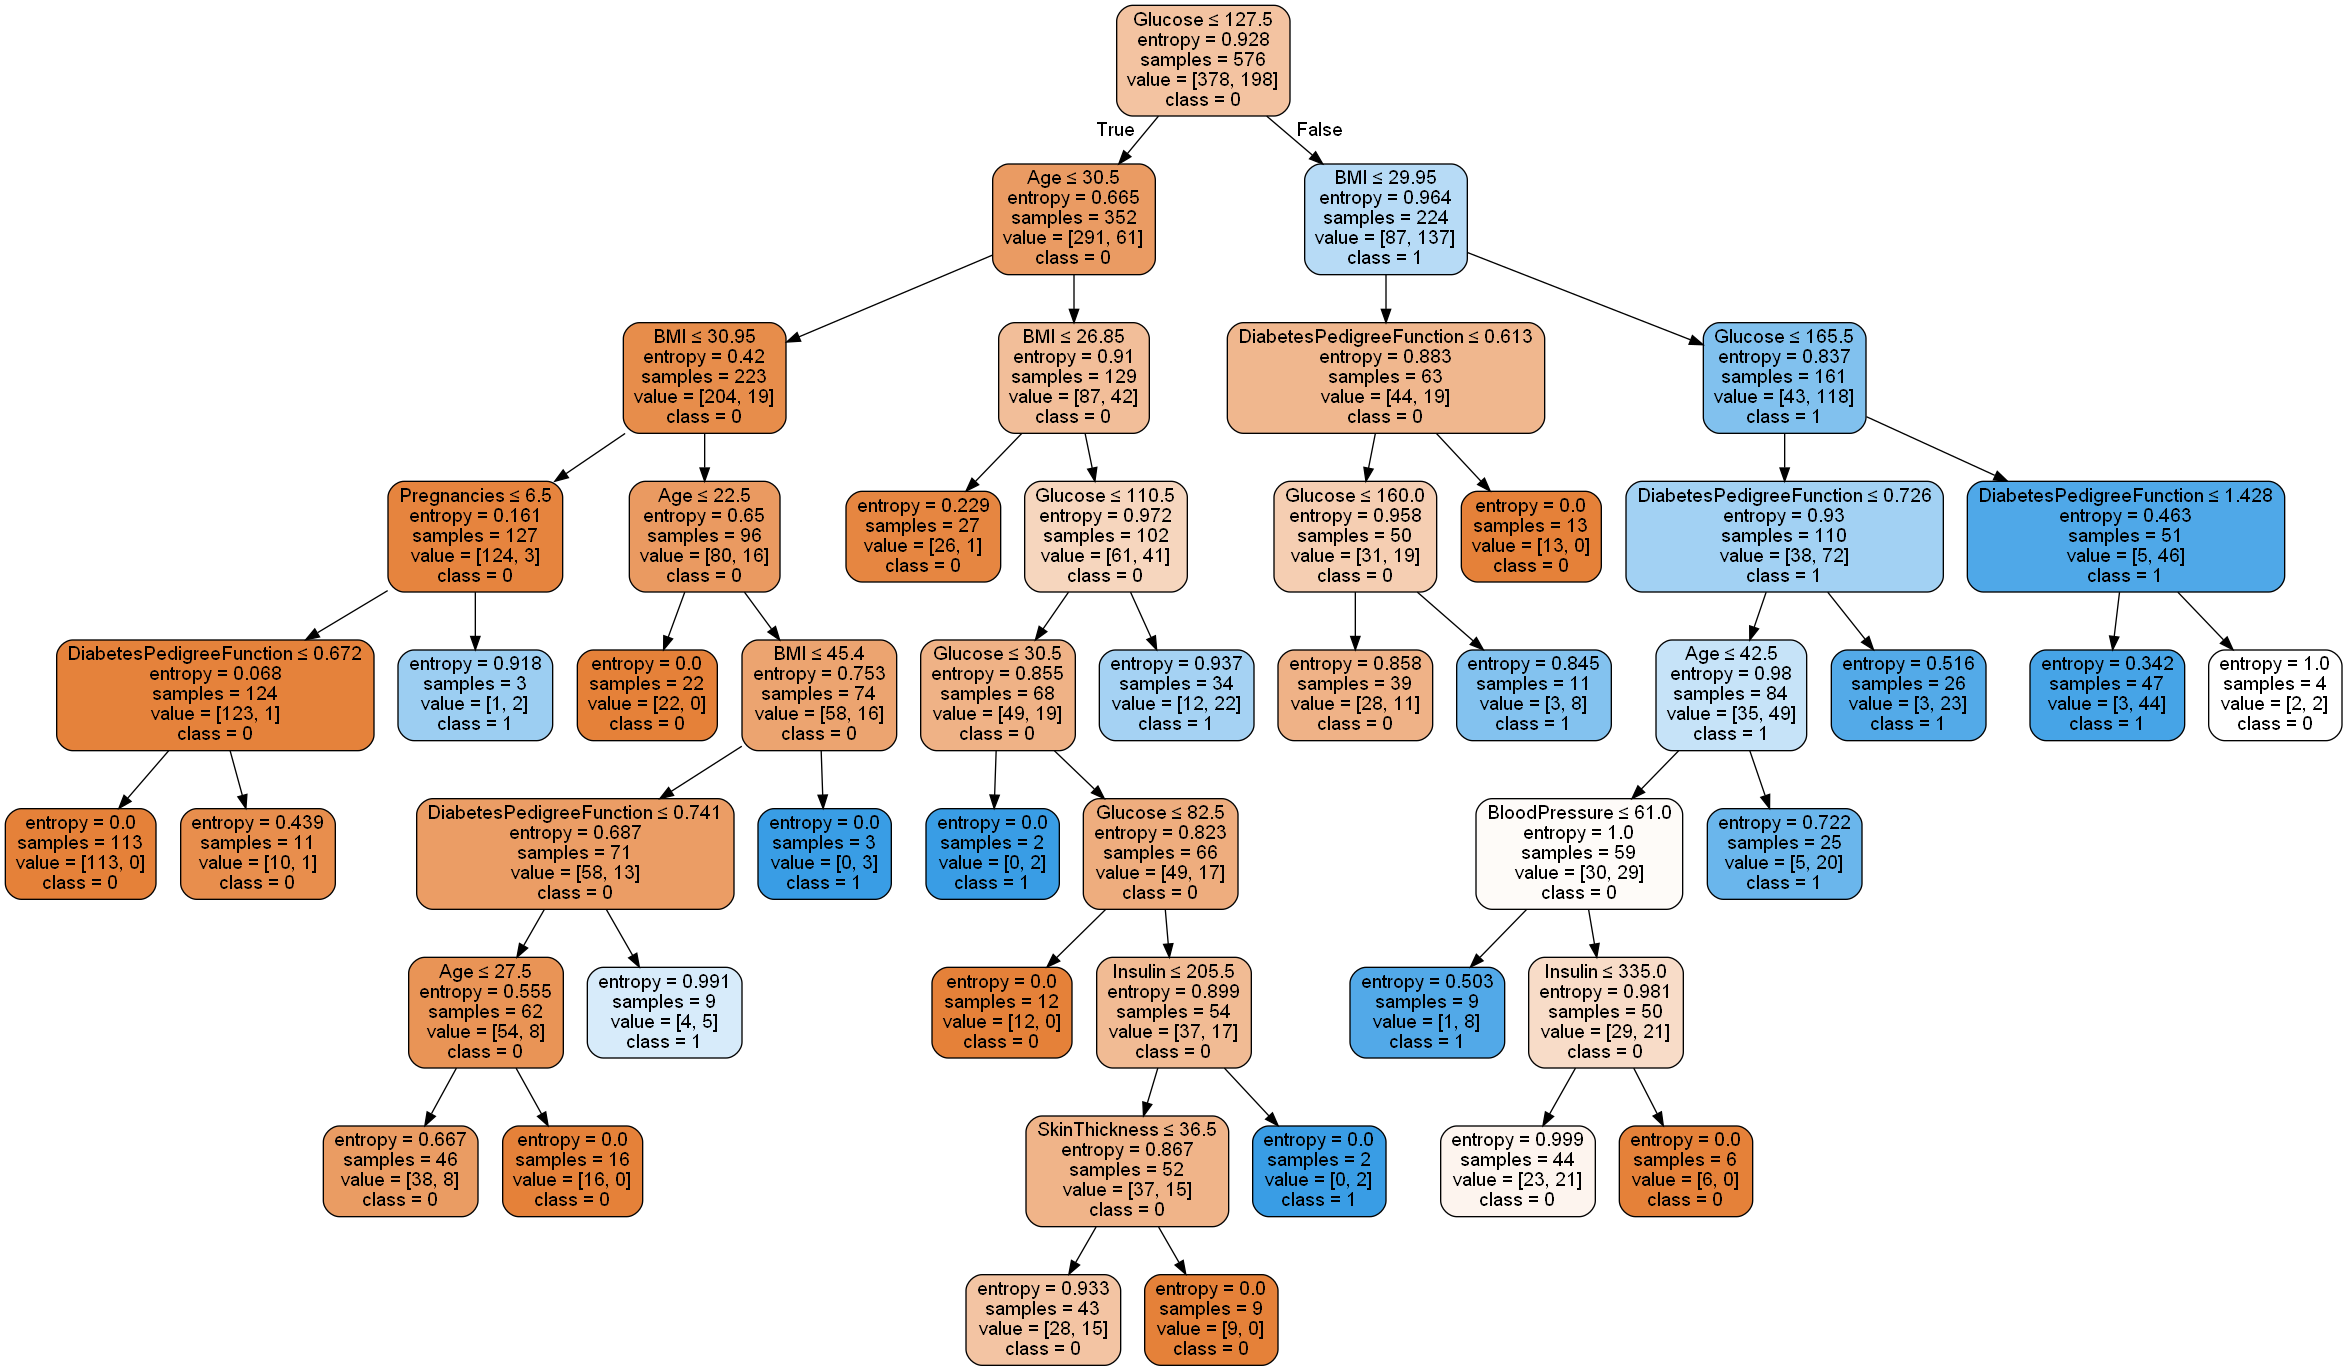

In [130]:
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image
import pydotplus

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data, filled=True, rounded=True,special_characters=True, feature_names=X.columns, class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())